In [8]:
pip install gdal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 838.1/838.1 kB 10.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [55 lines of output]
      Using numpy 1.17.3
      running egg_info
      writing gdal-utils/GDAL.egg-info/PKG-INFO
      writing dependency_links to gdal-utils/GDAL.egg-info/dependency_links.txt
      writing entry points to gdal-utils/GDAL.egg-info/entry_points.txt
      writing requirements to gdal-utils/GDAL.egg-info/requires.txt
      writing top-level names to gdal-utils/GDAL.egg-info/top_level.txt
      /private/var/folders/0z/hzm096lj0ln93813ky30xn1w0000gn/T/pip-build-env-6u6ksscx/overlay/lib/python3.8/site-packages/setuptools/config/_apply_pyprojecttoml.py:78: SetuptoolsWarning: `extras_require` overwritten in `pyproject.toml` (optional-dependencies)
        corresp(dist, value, ro

In [6]:
# step 1. load packages
import cv2
import numpy as np
import pandas as pd
from shapely.geometry import Point, MultiPolygon, Polygon
from shapely import wkt
import shapely
from osgeo import ogr, osr
import json

import matplotlib.pyplot as plt
import matplotlib.image as mpimg




ModuleNotFoundError: No module named 'osgeo'

In [33]:
# step 2. Read in data


# 2.1 Load manual segmentation

img = cv2.imread('./LFDP_over.jpg')
manual_segmentation =  ogr.Open("../data/manual_seg/manual_refine_label.shp")
layer = manual_segmentation.GetLayer()

def ogrWkt2Shapely(lyr):
    # this throws away the other attributes of the feature, but is 
    # sufficient in this use case
    shapely_objects=[] 
    for n in range(0, lyr.GetFeatureCount()):
        feat = lyr.GetFeature(n)
        wkt_feat = wkt.loads(feat.geometry().ExportToWkt())
        shapely_objects.append(wkt_feat)
    return shapely_objects



shapeObject = ogrWkt2Shapely(layer)


interior = [] # This stores whether the crown is completely inside the bounding box (30 by 30 quads)
indices = [] # Stores the image ID corresponding to the segmentation 
boxes = [] # Stores the coordinate of the corresponding bounding box
boxes_by_index = {} # Store the bounding boxes corresponding to indices


for shape in shapeObject:
    # identify the quadrant index
    center = shapely.centroid(shape)
    x_min = 202215.4732286049402319 
    y_min = 2028078.0600282789673656
    x_max = 202561.9119514034246095
    y_max = 2028607.4584284506272525
    x_resolution = (x_max - x_min)/10
    y_resolution = (y_max - y_min)/16
    x_index = (center.x - x_min)//x_resolution
    y_index = (center.y - y_min)//y_resolution
    index = '{0:03}'.format(int((15-y_index) * 10 + x_index + 1))
    indices.append(index)
    

    # check whether the polygon is the interior of the quadrant
    buffer = 2 # the size of buffer area which are not regarded as the interior 
    box = shapely.Polygon(((x_min + x_index * x_resolution + buffer, y_min + y_index * y_resolution + buffer),
                           (x_min + (1 + x_index) * x_resolution - buffer, y_min + y_index * y_resolution + buffer),
                           (x_min + (1 + x_index) * x_resolution - buffer, y_min + (1 + y_index) * y_resolution - buffer),
                           (x_min + x_index * x_resolution + buffer, y_min + (1 + y_index) * y_resolution - buffer),
                           (x_min + x_index * x_resolution + buffer, y_min + y_index * y_resolution + buffer)))
    boxes.append(box)
    if index not in boxes_by_index:
        boxes_by_index[index] = box
    interior.append(shape.within(box))
    
manual_polygons_by_ImgID = {}
manual_interior_polygons_by_ImgID = {}
for i in range(len(indices)):
    if indices[i] not in manual_polygons_by_ImgID:
        manual_polygons_by_ImgID[indices[i]]=[]
    # if interior[i]:
    x,y = shapeObject[i].exterior.coords.xy
    x = (np.array(x) - min(boxes_by_index[indices[i]].exterior.coords.xy[0]))/((x_max-x_min)/10000)
    y = (-np.array(y) + max(boxes_by_index[indices[i]].exterior.coords.xy[1]))/((y_max-y_min)/16000)
    v = []
    for j in range(len(x)):
        v.append((x[j],y[j]))
    manual_polygons_by_ImgID[indices[i]].append(Polygon(v))
    if interior[i]:
        if indices[i] not in manual_interior_polygons_by_ImgID:
            manual_interior_polygons_by_ImgID[indices[i]]=[]
        manual_interior_polygons_by_ImgID[indices[i]].append(Polygon(v))

# 2.2. Load Crowdsourcing MTurks Data
fn = './Batch_5161058_batch_results.csv'
datSub = pd.read_csv(fn)
# fn = './Batch_5161058_batch_results.csv'
# datSub = pd.concat([datSub,pd.read_csv(fn)],ignore_index=True)
# datSub.reset_index()

# Get all image indices
ImgID_list = []
for subID in range(datSub.shape[0]):
    ImgID = datSub.iloc[subID,27][-7:-4]
    ImgID_list.append(ImgID)
ImgID_list = list(set(ImgID_list))


polygons_by_ImgID = {}
Image_by_ImgID = {}
# Store polygons by ImgID
for subID in range(datSub.shape[0]):
    ImgID = datSub.iloc[subID,27][-7:-4]
    polygons = json.loads(datSub.iloc[subID, 30])
    if ImgID not in polygons_by_ImgID:
        # print('creating'+ImgID)
        polygons_by_ImgID[ImgID] = []
        Image_by_ImgID[ImgID] =  mpimg.imread("./patches/img_"+ImgID+".jpg",cv2.IMREAD_COLOR)
    if len(polygons) >=5:
        for polyGon in polygons:
            vertices = []
            for v in polyGon['vertices']:
                vertices.append((v['x'],v['y']))
            if len(vertices) >= 6:
                polygons_by_ImgID[ImgID].append(Polygon(vertices))
    

def IOU(polygon1, polygon2):
    intersect = polygon1.intersection(polygon2).area
    union = polygon1.union(polygon2).area
    return intersect / union
def calculate_IoU_mtx(polygon_list):
    n_poly = len(polygon_list)
    result = np.zeros((n_poly, n_poly))
    for i in range(n_poly-1):
        for j in range(i+1,n_poly):
            result[i][j] = IOU(polygon_list[i],polygon_list[j])
            result[j][i] = result[i][j]
    return result

# Store the confident crowded crowns with at least two similar segmentations
confident_crowns={}
for ImgID in ImgID_list:
    IOU_mtx = calculate_IoU_mtx(polygons_by_ImgID[ImgID])
    adj_mtx = np.zeros(IOU_mtx.shape)
    adj_mtx[IOU_mtx >= 0.5] = 1
    deg_of_vertices = np.apply_along_axis(sum,1,adj_mtx)
    confident_crowns[ImgID] = []
    for polyGon in [polygons_by_ImgID[ImgID][i] for i,x in enumerate(deg_of_vertices>=2) if x]:
        confident_crowns[ImgID].append(polyGon)



ERROR 1: PROJ: proj_identify: /Users/ganyuan/miniconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [4]:
# # THIS IS A SEPARATED SIDE TASK 
# # Create the shapefile for quads

# quads = MultiPolygon(list(set(boxes)))

# # Now convert it to a shapefile with OGR    
# driver = ogr.GetDriverByName('Esri Shapefile')
# ds = driver.CreateDataSource('../data/manual_seg/quad_30.shp')

# # create the spatial reference
# srs = osr.SpatialReference()
# srs.ImportFromEPSG(32620)

# layer = ds.CreateLayer('',srs, ogr.wkbPolygon)
# # Add one attribute
# layer.CreateField(ogr.FieldDefn('id', ogr.OFTInteger))
# defn = layer.GetLayerDefn()

# ## If there are multiple geometries, put the "for" loop here

# # Create a new feature (attribute and geometry)
# feat = ogr.Feature(defn)
# feat.SetField('id', 1)

# # Make a geometry, from Shapely object
# geom = ogr.CreateGeometryFromWkb(quads.wkb)
# feat.SetGeometry(geom)

# layer.CreateFeature(feat)
# feat = geom = None  # destroy these

# # Save and close everything
# ds = layer = feat = geom = None

In [17]:

# IOU_max_by_ImgID = {}
# for ImgID in ImgID_list:
#     IOU_max_list = []
#     for manual_polyGon in manual_polygons_by_ImgID[ImgID]:
#         IOU_max = 0
#         for crowd_polyGon in polygons_by_ImgID[ImgID]:
#             IOU_max = max(IOU_max, IOU(manual_polyGon,crowd_polyGon))
#         IOU_max_list.append(IOU_max)
#     IOU_max_by_ImgID[ImgID] = IOU_max_list



# Check what percentage of confident crowns are well-matched with manual crowns
matching_score = []
for ImgID in ImgID_list:
    for confident_polyGon in confident_crowns[ImgID]:
        IOU_max = 0
        for manual_polyGon in manual_polygons_by_ImgID[ImgID]:
            IOU_max = max(IOU_max, IOU(manual_polyGon,confident_polyGon))
        matching_score.append(IOU_max)

matching_score = np.array(matching_score)
matching_score = matching_score[matching_score>0]

In [18]:
matching_score.mean()

0.653350371432371

In [19]:
sum(np.array(matching_score)>0.5)/(matching_score.shape[0])

0.8277467411545624

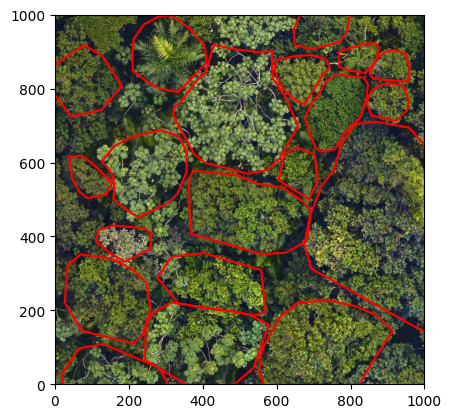

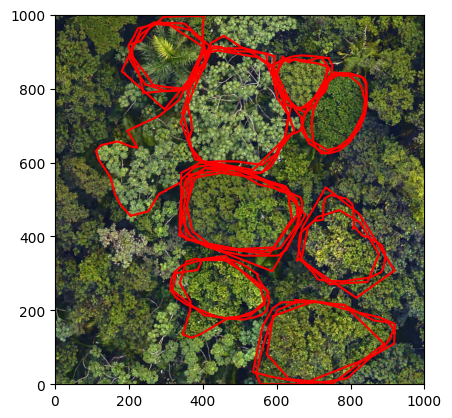

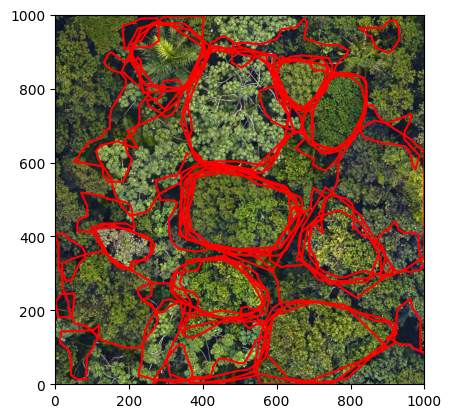

In [26]:
def show_polygons_over_image(image, polygons, color):
    plt.imshow(image)
    plt.xlim((0,1000))
    plt.ylim((0,1000))
    for polyGon in polygons:
        x,y = polyGon.exterior.coords.xy
        if color=='red':
            plt.plot(x,y,color=color)
        else:
            plt.plot(x,y)
    plt.show()
show_polygons_over_image(Image_by_ImgID[ImgID_list[7]],manual_polygons_by_ImgID[ImgID_list[7]],color='red')
show_polygons_over_image(Image_by_ImgID[ImgID_list[7]],confident_crowns[ImgID_list[7]], color='red')
show_polygons_over_image(Image_by_ImgID[ImgID_list[7]],polygons_by_ImgID[ImgID_list[7]], color='red')

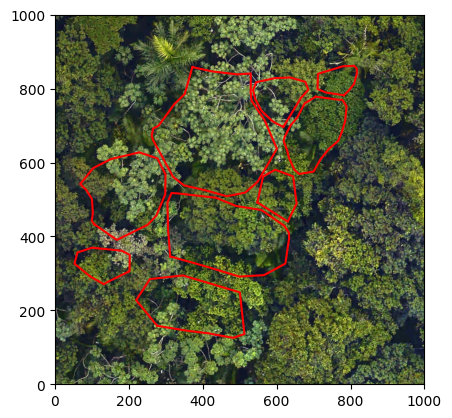

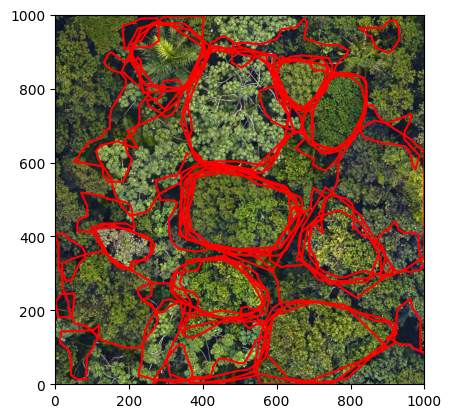

In [37]:
show_polygons_over_image(Image_by_ImgID[ImgID_list[7]],manual_interior_polygons_by_ImgID[ImgID_list[7]],color='red')
show_polygons_over_image(Image_by_ImgID[ImgID_list[7]],polygons_by_ImgID[ImgID_list[7]],color='red')

In [40]:
matching_score_2 = []
for ImgID in ImgID_list:
    for manual_polyGon in manual_interior_polygons_by_ImgID[ImgID]:
        IOU_max = 0
        for crowd_polyGon in polygons_by_ImgID[ImgID]:
            IOU_max = max(IOU_max, IOU(manual_polyGon,crowd_polyGon))
        matching_score_2.append(IOU_max)
matching_score_2 = np.array(matching_score_2)
print(len(matching_score_2))
matching_score_2 = matching_score_2[matching_score_2>0]
print(len(matching_score_2))


907
890


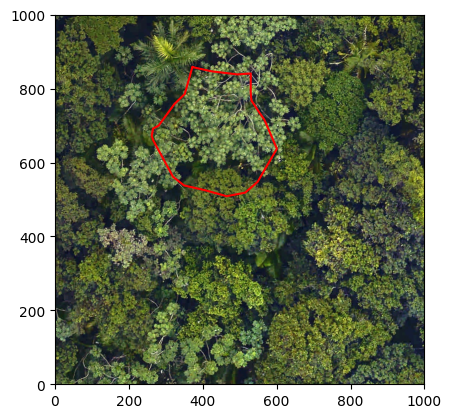

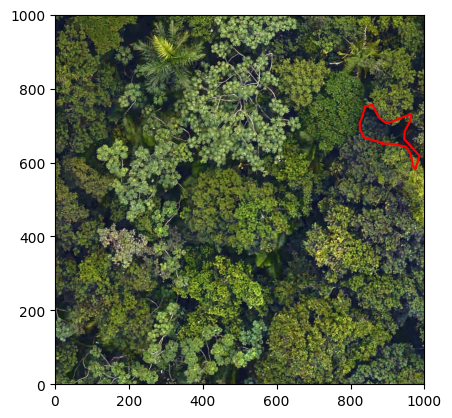

In [51]:
show_polygons_over_image(Image_by_ImgID[ImgID],manual_interior_polygons_by_ImgID[ImgID][0:1],color='red')
show_polygons_over_image(Image_by_ImgID[ImgID],polygons_by_ImgID[ImgID][5:6],color='red')

In [ ]:
manual_polyGon = manual_interior_polygons_by_ImgID[0]
IOU_max = 0
for crowd_polyGon in polygons_by_ImgID[ImgID]:
    if IOU_max <= IOU(crowd_polyGon,manual_polyGon):
        IOU_max = max(IOU_max, IOU(crowd_polyGon,manual_polyGon))

In [46]:
for manual_polyGon in manual_polygons_by_ImgID[ImgID]:
        IOU_max = 0
        for crowd_polyGon in polygons_by_ImgID[ImgID]:
            IOU_max = max(IOU_max, IOU(crowd_polyGon,manual_polyGon))
        print(IOU_max)

0.4337660183614384
0.4800304143466835
0.29653558036219424
0.3836272772114342
0.14511361024960637
0.46028204312060084
0.18128843443632323
0.14860087449546044
0.023656202066844614
0.4437500657317329
0.3056171063368015
0.32124540853148226
0.3715349007888734
0.47148911689557277
0.3516561062981977
0
0.11591574996666529
0.009970909377871751
0.338484934917078
0.08898757587227017


In [36]:
matching_score_2.mean(a)

0.23897589292589225

In [35]:
sum(matching_score_2>0.5)/len(matching_score_2)

0.06179775280898876

In [10]:
# step 3. split image
num = 1
for i in range(16):
    for j in range(10):
        r1 = i * 1000
        r2 = r1 + 1000
        c1 = j * 1000
        c2 = c1 + 1000
        imgSample = img[r1:r2, c1:c2]
        imgPath = 'patches/img_' + '{0:03}'.format(num) + '.jpg'
        cv2.imwrite(imgPath, imgSample)
        num += 1

In [11]:
# step 4. create index.csv
imgList = []
for i in range(1, 401):
    imgPath = 'https://mys7wj4bapocidsvm.blob.core.windows.net/lfdp-images/img_' + '{0:04}'.format(i) + '.jpg'
    imgList.append(imgPath)

In [12]:
pd.DataFrame({'img_url': imgList}).to_csv('index.csv', index=False)